In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import random
import gc
import lightgbm as lgb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import feather
import os
import glob
import csv   
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import datetime

Set seed

In [2]:
seed = 7
random.seed(seed)
np.random.seed(seed)

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Functions

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
#     time_format = "%Y-%m-%d %H:%M:%S"
#     start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
#     end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
#     start_date = weather_df['timestamp'].min()
#     end_date = weather_df['timestamp'].max()
#     total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
#     hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

#     missing_hours = []
#     for site_id in range(16):
#         site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
#         new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
#         new_rows['site_id'] = site_id
#         weather_df = pd.concat([weather_df,new_rows])

#         weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False) 
    new_air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_air_temperature'].mean(),columns=["new_air_temperature"])
    weather_df.update(new_air_temperature_filler,overwrite=False)

    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])
    weather_df.update(cloud_coverage_filler,overwrite=False)
    
    new_cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['new_cloud_coverage'].mean()
    new_cloud_coverage_filler = pd.DataFrame(new_cloud_coverage_filler.fillna(method='ffill'),columns=["new_cloud_coverage"])
    weather_df.update(new_cloud_coverage_filler,overwrite=False)
    
    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)
    new_due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_dew_temperature'].mean(),columns=["new_dew_temperature"])
    weather_df.update(new_due_temperature_filler,overwrite=False)

    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])
    weather_df.update(sea_level_filler,overwrite=False)
    
    new_sea_level_filler = weather_df.groupby(['site_id','day','month'])['new_sea_level_pressure'].mean()
    new_sea_level_filler = pd.DataFrame(new_sea_level_filler.fillna(method='ffill'),columns=['new_sea_level_pressure'])
    weather_df.update(new_sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)
    
    new_wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_wind_direction'].mean(),columns=['new_wind_direction'])
    weather_df.update(new_wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)
    new_wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_wind_speed'].mean(),columns=['new_wind_speed'])
    weather_df.update(new_wind_speed_filler,overwrite=False)

    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])
    weather_df.update(precip_depth_filler,overwrite=False)
    
    new_precip_depth_filler = weather_df.groupby(['site_id','day','month'])['new_precip_depth_1_hr'].mean()
    new_precip_depth_filler = pd.DataFrame(new_precip_depth_filler.fillna(method='ffill'),columns=['new_precip_depth_1_hr'])
    weather_df.update(new_precip_depth_filler,overwrite=False)
    
    uvIndex_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['uvIndex'].mean(),columns=['uvIndex'])
    weather_df.update(uvIndex_filler,overwrite=False)
    
    cloudCover_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['cloudCover'].mean(),columns=['cloudCover'])
    weather_df.update(cloudCover_filler,overwrite=False)
    
    humidity_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['humidity'].mean(),columns=['humidity'])
    weather_df.update(humidity_filler,overwrite=False)
    
    irradiance_cloud_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['irradiance_cloud'].mean(),columns=['irradiance_cloud'])
    weather_df.update(irradiance_cloud_filler,overwrite=False)
    
    feels_like_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['feels_like'].mean(),columns=['feels_like'])
    weather_df.update(feels_like_filler,overwrite=False)
    
    new_feels_like_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_feels_like'].mean(),columns=['new_feels_like'])
    weather_df.update(new_feels_like_filler,overwrite=False)
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df


In [7]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['sea_level_pressure', 'dew_temperature',
       'wind_speed', 'cloud_coverage', 'wind_direction', 'precip_depth_1_hr',
       'air_temperature', 'uvIndex', 'cloudCover', 'humidity', 'latitude',
       'longitude', 'irradiance_cloud', 'new_feels_like', 'radiation']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]
    return weather_df

# Load data

## weather

In [8]:
%%time
weather = feather.read_dataframe('../../data-vol-2/Prepared_data/weather.feather')
#weather['timestamp'] = weather['timestamp'].astype(str)
#weather['timestamp'] = pd.to_datetime(weather['timestamp'])

CPU times: user 43.6 ms, sys: 54.4 ms, total: 98 ms
Wall time: 509 ms


In [9]:
weather = fill_weather_dataset(weather)

In [10]:
weather.drop(['air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed','feels_like','altitude', 'azimuth', 'irradiance'],axis = 1, inplace=True)

weather.rename(columns = {'new_sea_level_pressure':'sea_level_pressure', 'new_dew_temperature': 'dew_temperature',
               'new_wind_speed':'wind_speed','new_cloud_coverage':'cloud_coverage', 
                'new_wind_direction':'wind_direction','new_precip_depth_1_hr':'precip_depth_1_hr', 
                'new_air_temperature':'air_temperature'},inplace=True)

In [11]:
weather = add_lag_feature(weather, window=72)

In [12]:
# windspeed feeling

beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    weather.loc[(weather['wind_speed']>=item[1]) & (weather['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

## Train data

In [13]:
%%time
train = feather.read_dataframe('../../data-vol-2/Prepared_data/train_prepared.feather')
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['meter_reading'] = np.log1p(train['meter_reading'])
#train.drop(columns=['utc','utc_time','altitude','azimuth'], inplace=True)


CPU times: user 3.45 s, sys: 3.76 s, total: 7.21 s
Wall time: 42.3 s


In [14]:
train = train.drop(columns=['air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed',
       'new_sea_level_pressure', 'new_dew_temperature', 'new_wind_speed',
       'new_cloud_coverage', 'new_wind_direction', 'new_precip_depth_1_hr',
       'new_air_temperature', 'uvIndex', 'cloudCover', 'humidity', 'latitude',
       'longitude', 'irradiance', 'irradiance_cloud', 'feels_like',
       'new_feels_like', 'altitude', 'azimuth', 'radiation'])

In [15]:
train = train[train['site_id'].isin([0,1,2])]
gc.collect()

20

In [16]:
train = train.merge(weather, on=['site_id', 'timestamp'], how='left')

In [17]:
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.day
train['hour'] = train['timestamp'].dt.hour
train['weekday'] = train['timestamp'].dt.weekday
train['age'] = train['year'] - train['year_built']

pd.set_option('display.max_rows', 500)
cols = ['floor_count']
train.loc[:, cols] = train.loc[:, cols].interpolate(axis=0)

new_df = train.groupby(by=['building_id'], as_index=False)['timestamp'].min()
new_df = new_df.rename(columns = {'timestamp': 'start_ts'})
train = train.merge(new_df, on = 'building_id', how='left')
train['hours_passed'] = (train['timestamp'] - train['start_ts']).dt.total_seconds()/3600

In [18]:
train = reduce_mem_usage(train)

Mem. usage decreased to 845.20 Mb (45.1% reduction)


## Test

In [19]:
%%time
test = feather.read_dataframe(f'../../data-vol-3/Prepared_data/test_leaked_prepared.feather')
test.dropna(subset=['meter_reading'],inplace=True)

CPU times: user 2.87 s, sys: 2.82 s, total: 5.69 s
Wall time: 24.1 s


In [20]:
test = test.drop(columns=['air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed',
       'new_sea_level_pressure', 'new_dew_temperature', 'new_wind_speed',
       'new_cloud_coverage', 'new_wind_direction', 'new_precip_depth_1_hr',
       'new_air_temperature', 'uvIndex', 'cloudCover', 'humidity', 'latitude',
       'longitude', 'irradiance', 'irradiance_cloud', 'feels_like',
       'new_feels_like', 'altitude', 'azimuth', 'radiation'])

In [21]:
test = test.merge(weather, on=['site_id', 'timestamp'], how='left')

In [22]:
test['year'] = test['timestamp'].dt.year
test['month'] = test['timestamp'].dt.month
test['day'] = test['timestamp'].dt.day
test['hour'] = test['timestamp'].dt.hour
test['weekday'] = test['timestamp'].dt.weekday
test['age'] = test['year'] - test['year_built']

pd.set_option('display.max_rows', 500)
cols = ['floor_count']
test.loc[:, cols] = test.loc[:, cols].interpolate(axis=0)

new_df = test.groupby(by=['building_id'], as_index=False)['timestamp'].min()
new_df = new_df.rename(columns = {'timestamp': 'start_ts'})
test = test.merge(new_df, on = 'building_id', how='left')
test['hours_passed'] = (test['timestamp'] - test['start_ts']).dt.total_seconds()/3600


In [23]:
cat_cols = ['meter', 'primary_use', 'site_id', 'is_day_saving','is_holiday', 'year', 'month', 'day', 'hour']
le = LabelEncoder()

for col in cat_cols:
#     test[col] = test[col].astype('category')
#     train[col] = train[col].astype('category')   
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

In [24]:
test = reduce_mem_usage(test)

Mem. usage decreased to 1966.42 Mb (48.4% reduction)


# Create train test split

In [30]:
cv_method = 'stratified_month_usage'
n_split = 5
version = 2
model_name = 'lgbm'

train['split'] = (train['primary_use'] + train['timestamp'].dt.month - 1) % n_split

In [31]:
features = [col for col in train.columns if col not in ['meter_reading', 'split', 'utc_time', 'timestamp', 'start_ts']]
     
target = 'meter_reading'

# remove outliers

In [32]:
train = train [train['building_id'] != 1099 ]
train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Train model

In [ ]:
# group = train['site_id'].astype(str) + "_" + (train['timestamp'].dt.month).astype(str)
# groupSplit = GroupShuffleSplit(n_split, test_size=0.2, random_state=7)
# folds = groupSplit.split(train[['radiation']],
#                          train['meter_reading'],
#                          groups=[train['site_id'],train['timestamp'].dt.month])

# LightGBM

In [33]:
lgb_params = {
              'objective':'regression',
              'boosting_type':'gbdt',
              'metric':'rmse',
              'n_jobs':-1,
              'learning_rate':0.05,
              'num_leaves': 2**8,
              'max_depth':-1,
              'tree_learner':'serial',
              'colsample_bytree': 0.9,
              'subsample_freq':1,
              'subsample':0.5,
              'n_estimators':2000,
              'max_bin':255,
              'verbose':2,
              'seed': seed,
              'early_stopping_rounds':100 
            } 

mean_performance_test = 0 
mean_performance_train = 0
mean_performance_leaked = 0
gc.collect()

50

In [34]:
for fold in range(n_split):  
    print(f"\n\n\n ===== Fold numer {fold} =====")
    tr_data = lgb.Dataset(train.loc[train['split'].ne(fold)][features], 
                          label=train.loc[train['split'].ne(fold)][target])
    vl_data = lgb.Dataset(train.loc[train['split'].eq(fold)][features], 
                          label=train.loc[train['split'].eq(fold)][target])
    gc.collect()
    estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data,vl_data],
                verbose_eval = 50)
    model_filename = 'models/' + model_name + '_' + cv_method + '_fold_' + str(fold)  + '.bin'
    pickle.dump(estimator, open(model_filename, 'wb'))
    
    performance_test = estimator.best_score['valid_1']['rmse']
    performance_train = estimator.best_score['training']['rmse']

    mean_performance_test += performance_test
    mean_performance_train += performance_train
    gc.collect()
    
    i = 0
    step = 100000
    test['pred'] = np.nan
    while i < test.shape[0]:
        test.loc[i:(i+step-1),'pred'] = estimator.predict(test.iloc[i:(i+step)][features])
        i = i + step
        gc.collect()
    print("Done with the test prediction")
    
    performance_leaked = np.sqrt(mean_squared_error(test['meter_reading_log'],test['pred']))
    mean_performance_leaked += performance_leaked
    
    with open(r'./models/perf_leaked.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([cv_method, fold, performance_train, performance_test, performance_leaked])

    print((mean_performance_train/(fold+1)),(mean_performance_test/(fold+1)),(mean_performance_leaked/(fold+1)))




 ===== Fold numer 0 =====


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.660448	valid_1's rmse: 0.809744
[100]	training's rmse: 0.528551	valid_1's rmse: 0.740536
[150]	training's rmse: 0.479366	valid_1's rmse: 0.717816
[200]	training's rmse: 0.450219	valid_1's rmse: 0.708365
[250]	training's rmse: 0.430532	valid_1's rmse: 0.701853
[300]	training's rmse: 0.415985	valid_1's rmse: 0.69854
[350]	training's rmse: 0.403632	valid_1's rmse: 0.695138
[400]	training's rmse: 0.393576	valid_1's rmse: 0.692844
[450]	training's rmse: 0.384706	valid_1's rmse: 0.690888
[500]	training's rmse: 0.376716	valid_1's rmse: 0.689268
[550]	training's rmse: 0.369297	valid_1's rmse: 0.688106
[600]	training's rmse: 0.363423	valid_1's rmse: 0.68719
[650]	training's rmse: 0.358043	valid_1's rmse: 0.686573
[700]	training's rmse: 0.353361	valid_1's rmse: 0.685833
[750]	training's rmse: 0.348884	valid_1's rmse: 0.685153
[800]	training's rmse: 0.344741	valid_1's rmse: 0.684568
[850]	training's rmse: 0.3402

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.658599	valid_1's rmse: 0.817095
[100]	training's rmse: 0.530865	valid_1's rmse: 0.738841
[150]	training's rmse: 0.481457	valid_1's rmse: 0.716774
[200]	training's rmse: 0.454007	valid_1's rmse: 0.705875
[250]	training's rmse: 0.434615	valid_1's rmse: 0.699113
[300]	training's rmse: 0.421104	valid_1's rmse: 0.695348
[350]	training's rmse: 0.409023	valid_1's rmse: 0.691896
[400]	training's rmse: 0.398661	valid_1's rmse: 0.688801
[450]	training's rmse: 0.389969	valid_1's rmse: 0.686474
[500]	training's rmse: 0.382899	valid_1's rmse: 0.685153
[550]	training's rmse: 0.376289	valid_1's rmse: 0.683875
[600]	training's rmse: 0.369657	valid_1's rmse: 0.682325
[650]	training's rmse: 0.364578	valid_1's rmse: 0.681272
[700]	training's rmse: 0.359719	valid_1's rmse: 0.680484
[750]	training's rmse: 0.354913	valid_1's rmse: 0.679625
[800]	training's rmse: 0.350208	valid_1's rmse: 0.678677
[850]	training's rmse: 0.34

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.673251	valid_1's rmse: 0.762518
[100]	training's rmse: 0.543132	valid_1's rmse: 0.67676
[150]	training's rmse: 0.492856	valid_1's rmse: 0.653261
[200]	training's rmse: 0.462424	valid_1's rmse: 0.644037
[250]	training's rmse: 0.442644	valid_1's rmse: 0.637902
[300]	training's rmse: 0.42884	valid_1's rmse: 0.634136
[350]	training's rmse: 0.417936	valid_1's rmse: 0.631604
[400]	training's rmse: 0.407407	valid_1's rmse: 0.629155
[450]	training's rmse: 0.398299	valid_1's rmse: 0.62652
[500]	training's rmse: 0.390526	valid_1's rmse: 0.62483
[550]	training's rmse: 0.383263	valid_1's rmse: 0.623307
[600]	training's rmse: 0.376702	valid_1's rmse: 0.62178
[650]	training's rmse: 0.371009	valid_1's rmse: 0.621109
[700]	training's rmse: 0.365327	valid_1's rmse: 0.620103
[750]	training's rmse: 0.360863	valid_1's rmse: 0.619545
[800]	training's rmse: 0.356482	valid_1's rmse: 0.618773
[850]	training's rmse: 0.352212	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.670123	valid_1's rmse: 0.736069
[100]	training's rmse: 0.5402	valid_1's rmse: 0.645209
[150]	training's rmse: 0.488459	valid_1's rmse: 0.619311
[200]	training's rmse: 0.45882	valid_1's rmse: 0.607705
[250]	training's rmse: 0.439859	valid_1's rmse: 0.601295
[300]	training's rmse: 0.42508	valid_1's rmse: 0.597124
[350]	training's rmse: 0.413714	valid_1's rmse: 0.593901
[400]	training's rmse: 0.402945	valid_1's rmse: 0.591015
[450]	training's rmse: 0.394286	valid_1's rmse: 0.588989
[500]	training's rmse: 0.386754	valid_1's rmse: 0.587313
[550]	training's rmse: 0.379898	valid_1's rmse: 0.585597
[600]	training's rmse: 0.37397	valid_1's rmse: 0.584291
[650]	training's rmse: 0.368095	valid_1's rmse: 0.583369
[700]	training's rmse: 0.363111	valid_1's rmse: 0.582533
[750]	training's rmse: 0.357804	valid_1's rmse: 0.581373
[800]	training's rmse: 0.353174	valid_1's rmse: 0.580438
[850]	training's rmse: 0.348757	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.672524	valid_1's rmse: 0.784954
[100]	training's rmse: 0.542997	valid_1's rmse: 0.701008
[150]	training's rmse: 0.492103	valid_1's rmse: 0.67677
[200]	training's rmse: 0.461869	valid_1's rmse: 0.661843
[250]	training's rmse: 0.441687	valid_1's rmse: 0.653272
[300]	training's rmse: 0.425741	valid_1's rmse: 0.647843
[350]	training's rmse: 0.412628	valid_1's rmse: 0.643403
[400]	training's rmse: 0.403279	valid_1's rmse: 0.640511
[750]	training's rmse: 0.357347	valid_1's rmse: 0.630256
[800]	training's rmse: 0.352742	valid_1's rmse: 0.629216
[850]	training's rmse: 0.348564	valid_1's rmse: 0.628602
[900]	training's rmse: 0.345051	valid_1's rmse: 0.628258
[950]	training's rmse: 0.341395	valid_1's rmse: 0.627758
[1000]	training's rmse: 0.338292	valid_1's rmse: 0.627313
[1050]	training's rmse: 0.334849	valid_1's rmse: 0.626843
[1100]	training's rmse: 0.331767	valid_1's rmse: 0.626401
[1150]	training's rmse: 0

# Feature importance

In [37]:
estimator = pickle.load(open('models/lgbm_stratified_building_id_month_fold_4.bin', 'rb'))

<Figure size 3600x4320 with 0 Axes>

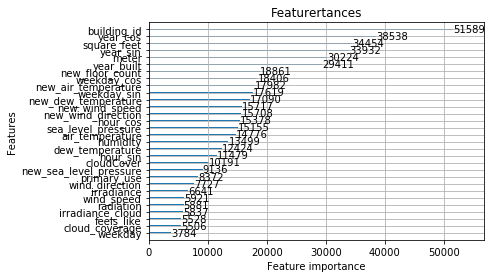

In [49]:
import matplotlib.pyplot as plt


plt.figure(figsize=(50,60))
lgb.plot_importance(estimator, max_num_features=30)
plt.title("Featurertances")
plt.show()

In [44]:
estimator.feature_importance())

[51589,
 30224,
 429,
 8372,
 34454,
 29411,
 18861,
 1354,
 18406,
 17619,
 3784,
 15378,
 11479,
 38538,
 33932,
 835,
 14776,
 5506,
 12424,
 988,
 15155,
 5921,
 10191,
 13499,
 6641,
 5528,
 5837,
 2146,
 2524,
 2013,
 9136,
 17090,
 15717,
 562,
 2383,
 17982,
 15708,
 5881,
 7727]

In [43]:
features

['building_id',
 'meter',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'utc',
 'new_floor_count',
 'new_year_built',
 'square_feet_log',
 'is_holiday',
 'weekday_cos',
 'weekday_sin',
 'weekday',
 'hour_cos',
 'hour_sin',
 'year_cos',
 'year_sin',
 'night_time',
 'morning',
 'afternoon',
 'evening',
 'is_day_saving',
 'sea_level_pressure',
 'dew_temperature',
 'wind_speed',
 'cloud_coverage',
 'wind_direction',
 'precip_depth_1_hr',
 'air_temperature',
 'uvIndex',
 'cloudCover',
 'humidity',
 'latitude',
 'longitude',
 'irradiance_cloud',
 'new_feels_like',
 'radiation',
 'sea_level_pressure_mean_lag72',
 'sea_level_pressure_max_lag72',
 'sea_level_pressure_min_lag72',
 'sea_level_pressure_std_lag72',
 'dew_temperature_mean_lag72',
 'dew_temperature_max_lag72',
 'dew_temperature_min_lag72',
 'dew_temperature_std_lag72',
 'wind_speed_mean_lag72',
 'wind_speed_max_lag72',
 'wind_speed_min_lag72',
 'wind_speed_std_lag72',
 'cloud_coverage_mean_lag72',
 'clou

In [ ]:
i = 0
step = 100000
test['pred'] = np.nan
while i < test.shape[0]:
    test.loc[i:(i+step-1),'pred'] = estimator.predict(test.iloc[i:(i+step)][features])
    i = i + step
    gc.collect()
print("Done with the test prediction")

In [ ]:
test.dtypes

In [ ]:
train.dtypes

In [ ]:
test['meter_reading_log'].loc[0:100].plot()
test['pred'].loc[0:100].plot()

In [ ]:
start = 26600
end = 26700
test['meter_reading_log'].iloc[start:end].plot()
test['pred'].iloc[start:end].plot()

# Save results

In [ ]:
mean_performance_leaked = mean_performance_leaked/n_split
mean_performance_test = mean_performance_test/n_split
mean_performance_train = mean_performance_train/n_split

with open(r'./models/perf_leaked.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([cv_method, 'avg', mean_performance_train, mean_performance_test, mean_performance_leaked])

# Backup Code

In [ ]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    train.loc[(train['wind_speed']>=item[1]) & (train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]
    train.loc[(train['new_wind_speed']>=item[1]) & (train['new_wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [ ]:
le = LabelEncoder()

for f in ['meter','primary_use','is_day_saving','is_holiday']:
    train[f] = train[f].astype('category')
    train[f] = le.fit_transform(train[f])